In [1]:
import pandas as pd
import os
import requests
import pdfplumber
import re
import numpy as np
import fitz
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from collections import Counter

In [2]:
''' The purpose of ScrapCibcQuaterlyReport class is scrap cibc quaterly report of shareholders
This class involves following steps:
1. Creatign a directory named cibc_quarterly_reports
2. Define years and quarters range
3. download reports and save it to folder path
'''
class ScrapCibcQuaterlyReport():
    def __init__(self, year_start, year_end, folder_name):
        self.year_start = year_start
        self.year_end = year_end
        self.folder_name = folder_name

    def create_directory(self):
        os.makedirs(self.folder_name, exist_ok=True)

    def define_years_quarter_range(self):
        self.years = range(self.year_start, self.year_end+1)
        self.quarters = [1, 2, 3, 4]

    def download_reports(self):
        for year in self.years:
            for quarter in self.quarters:
                if self.year_start <= year <= 2009:
                    year_suffix = str(year)[-2:]
                    url = f"https://www.cibc.com/content/dam/about_cibc/investor_relations/pdfs/quarterly_results/{year}/q{quarter}{year_suffix}report.pdf"
                elif 2010 <= year <= 2016:
                    url = f"https://www.cibc.com/content/dam/about_cibc/investor_relations/pdfs/quarterly_results/{year}/q{quarter}{year % 100}report.pdf"
                elif 2017 <= year <= 2021:
                    url = f"https://www.cibc.com/content/dam/about_cibc/investor_relations/pdfs/quarterly_results/{year}/q{quarter}{year % 100}report-en.pdf"
                else:
                    url = f"https://www.cibc.com/content/dam/cibc-public-assets/about-cibc/investor-relations/pdfs/quarterly-results/{year}/q{quarter}{year % 100}report-en.pdf"

                filename = f"cibc_q{quarter}_{year}.pdf"
                file_path = os.path.join(self.folder_name, filename)

                print("Downloading report from :", url)
                response = requests.get(url)

                if response.status_code == 200:
                    # Save the PDF to the local folder
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                else:
                    print(f"Failed to download report with status code: {response.status_code}")

scrap_report = ScrapCibcQuaterlyReport(2005, 2024, 'cibc_quarterly_reports')
scrap_report.create_directory()
scrap_report.define_years_quarter_range()
scrap_report.download_reports()

Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status code: 404
Failed to download report with status co

# Text Extraction from reports

In [3]:
''' The purpose of ExtractAndCleanTextFromReports class is to read texts from pdf and clean the data
This class involves following steps:
1. Read pdf reports from directory
2. Split the reports into train(2005-2020) and test(2021-2024)
3. Convert clean text to dataframe
'''
import re
import fitz  # PyMuPDF
import pandas as pd
import os

class ExtractAndCleanTextFromReports:
    def __init__(self, folder_name):
        self.folder_name = folder_name

    def extract_text(self, pdf_path, start_page, end_page):
        text = ''
        with fitz.open(pdf_path) as doc:
            for i in range(start_page, end_page):
                page = doc.load_page(i)
                text += page.get_text("text")
        return text

    def clean_sentences(self, text):    
        text = re.sub(r'http\S+|www.\S+', '', text)
        text = re.sub(r'(A NOTE ABOUT FORWARD-LOOKING STATEMENTS|External reporting changes|Contents).*?(?=\n\n|\Z)', '', text, flags=re.DOTALL)
        text = re.sub(r'\d+(\s+\d+)+', '', text)
        text = re.sub(r'\n+', ' ', text)
        
        sentences = re.split(r'(?<=\.|;|!|\?)\s+', text) 
        sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
        sentences = [re.sub(r'\b(?:million|billion|thousand|Q)\b', '', sentence, flags=re.IGNORECASE) for sentence in sentences]
        sentences = [re.sub(r'\d+', '', sentence) for sentence in sentences]
        sentences = [re.sub(r'[^\w\s]', '', sentence) for sentence in sentences] 
        sentences = [re.sub(r'\bcibc\b', '', sentence, flags=re.IGNORECASE) for sentence in sentences]
        sentences = [re.sub(r'\bcanada\b', '', sentence, flags=re.IGNORECASE) for sentence in sentences]
    
        filtered_sentences = [sentence for sentence in sentences if len(sentence.split()) >= 30]    
        return filtered_sentences

    def extract_year(self, filename):
        match = re.search(r'_(\d{4})\.pdf', filename)
        if match:
            return int(match.group(1))
        else:
            print("Year not found in filename")

    def extract_and_clean_reports(self):
        self.all_sentences = []
        for filename in os.listdir(self.folder_name):
            if filename.endswith('.pdf'): 
                pdf_path = os.path.join(self.folder_name, filename)
                print(f"Processing :", filename)
    
                year = self.extract_year(filename)            
                total_pages = len(fitz.open(pdf_path))
                extracted_text = self.extract_text(pdf_path, start_page=7, end_page=total_pages-3)
                filtered_sentences = self.clean_sentences(extracted_text)
                for sentence in filtered_sentences:
                    self.all_sentences.append({'Sentence': sentence, 'year': year})

        self.sentence_df = pd.DataFrame(self.all_sentences)
        self.sentence_df['Sentence'] = self.sentence_df['Sentence'].apply(lambda x: re.sub(r'\s{2,}', ' ', x).strip())
    
    def split_train_test(self):
        self.df_train = self.sentence_df[self.sentence_df['year'].between(2005, 2018)]
        self.df_test = self.sentence_df[self.sentence_df['year'].between(2019, 2024)]    


folder_name = 'cibc_quarterly_reports'
clean_extract_reports = ExtractAndCleanTextFromReports(folder_name)
clean_extract_reports.extract_and_clean_reports()
clean_extract_reports.split_train_test()

df_train = clean_extract_reports.df_train
df_test = clean_extract_reports.df_test

print("Training DataFrame:")
print(df_train.head())
print("\nTesting DataFrame:")
print(df_test.head())

Processing : cibc_q1_2005.pdf
Processing : cibc_q1_2006.pdf
Processing : cibc_q1_2007.pdf
Processing : cibc_q1_2008.pdf
Processing : cibc_q1_2009.pdf
Processing : cibc_q1_2010.pdf
Processing : cibc_q1_2011.pdf
Processing : cibc_q1_2012.pdf
Processing : cibc_q1_2013.pdf
Processing : cibc_q1_2014.pdf
Processing : cibc_q1_2015.pdf
Processing : cibc_q1_2016.pdf
Processing : cibc_q1_2017.pdf
Processing : cibc_q1_2018.pdf
Processing : cibc_q1_2019.pdf
Processing : cibc_q1_2020.pdf
Processing : cibc_q1_2021.pdf
Processing : cibc_q1_2022.pdf
Processing : cibc_q1_2023.pdf
Processing : cibc_q1_2024.pdf
Processing : cibc_q2_2005.pdf
Processing : cibc_q2_2006.pdf
Processing : cibc_q2_2007.pdf
Processing : cibc_q2_2008.pdf
Processing : cibc_q2_2009.pdf
Processing : cibc_q2_2010.pdf
Processing : cibc_q2_2011.pdf
Processing : cibc_q2_2012.pdf
Processing : cibc_q2_2013.pdf
Processing : cibc_q2_2014.pdf
Processing : cibc_q2_2015.pdf
Processing : cibc_q2_2016.pdf
Processing : cibc_q2_2017.pdf
Processing

In [4]:
df_test.shape

(3666, 2)

# Rule-Based Labeling

In [5]:
''' The purpose of this class is to label paragraph into four category: 
[Risk and Capital-related Class, Income and Risk-related Class, Income-related Class, Investment and Shareholder-related Class, Uncategorized]
This class involves following steps: 
1. Defining patterns with income_pattern and risk_pattern
2. split text into paragraphs of df_train
3. label each paragraph by matching the pattern with re.search()
4. Store the dictionary output into dataframe
'''

class RuleBasedLabeling:
    def __init__(self, df):
        self.df = df

        self.income_patterns = [
            r'revenue', r'net income', r'earnings', r'profit', r'eps', r'income',
            r'financial results', r'interest margin', r'growth in income', r'sales',
            r'financial performance', r'operating income', r'non-interest income',
            r'net interest', r'net profit', r'taxes', r'margin', r'income tax',
            r'quarterly income', r'operational results', r'cost of goods', r'cash flow', r' principal and interest', r'loan', r'funding', r'interest'
        ]

        self.risk_patterns = [
            r'credit risk', r'market risk', r'liquidity risk', r'capital adequacy',
            r'provision for credit losses', r'exposure', r'risk-weighted assets',
            r'capital buffer', r'capital ratio', r'volatility', r'non-performing loans',
            r'loan loss provisions', r'operational risk', r'cybersecurity risk',
            r'compliance risk', r'reputational risk', r'regulatory risk',
            r'loan to value', r'capital risk', r'interest rate risk', r'hedging',
            r'risk management', r'risk exposure', r'mitigation techniques',
            r'insured vs uninsured loans', r'risk level', r'netting agreements',
            r'cash collateral', r'credit spread risk', r'foreign exchange risk',
            r'commodity risk', r'structural interest rate risk', r'enterprise risk',
            r'financial instability', r'market volatility', r'contingency plans',
            r'operational resilience', r'loss provisions', r'credit spread', r'credit losses', r'financial liabilities', r'unpaid interest', 
            r'exchange losses', r'Legal risk', r'ValueatRisk', r'liabilities'
        ]

        self.investment_and_shareholder_patterns = [
            r'dividend', r'shareholder', r'stock', r'return on equity', r'capital return',
            r'asset management', r'equity', r'share buyback', r'investment return',
            r'market value', r'valuation', r'investors' r'expenses', r'policies', r'disclosures' , r'noninterest', r'liquidity facilities', 
            r'protection from loss', r'significant developments', r'legal', r' controls', r'procedures', r'timeline', r'benefit plan', r'capital'
            r'liquidity'
        ]

    def sentence_labeling(self, sentence):
        """Assigns a label to a sentence based on the presence of income and risk-related patterns."""
        lowercase_sentence = sentence.lower()

        income_match_count = sum(bool(re.search(pattern, lowercase_sentence)) for pattern in self.income_patterns)
        risk_match_count = sum(bool(re.search(pattern, lowercase_sentence)) for pattern in self.risk_patterns)
        investment_and_shareholder_count = sum(bool(re.search(pattern, lowercase_sentence)) for pattern in self.investment_and_shareholder_patterns)

        if income_match_count > 0 and risk_match_count > 0:
            if risk_match_count > income_match_count:
                return 'Risk and Capital-related Class'
            else:
                return 'Income and Risk-related Class'
        elif income_match_count > 0:
            return 'Income-related Class'
        elif risk_match_count > 0:
            return 'Risk and Capital-related Class'
        elif investment_and_shareholder_count > 0:
            return 'Investment and Shareholder-related Class'
        else:
            return 'Uncategorized'

    def convert_to_dataframe(self, classified_sentences):
        """Converts the classified sentences into a Pandas DataFrame."""
        return pd.DataFrame(classified_sentences)

    def rule_based_classification(self):
        """Performs rule-based classification on each sentence in the dataframe."""
        classified_sentences = []
        uncategorized_sentences = []

        for idx, row in self.df.iterrows():
            year = row['year']
            sentence = row['Sentence']

            category = self.sentence_labeling(sentence)

            classified_sentences.append({
                'year': year,
                'sentence': sentence,
                'category': category
            })
            if category == 'Uncategorized':
                uncategorized_sentences.append(sentence)
        return self.convert_to_dataframe(classified_sentences)

rule_based_labeling_train = RuleBasedLabeling(df_train)
df_classified = rule_based_labeling_train.rule_based_classification()
print(df_classified.head())

rule_based_labeling_test = RuleBasedLabeling(df_test)
df_classified_test = rule_based_labeling_test.rule_based_classification()
print(df_classified_test.head())

   year                                           sentence  \
0  2005  Revenue Retail Markets Wealth Management Comme...   
1  2005  Net interest income was up from the prior quar...   
2  2005  Noninterest income Noninterest income was up f...   
3  2005  Noninterest income was up from the prior quart...   
4  2005  Provision for credit losses Provision for cred...   

                         category  
0            Income-related Class  
1   Income and Risk-related Class  
2            Income-related Class  
3            Income-related Class  
4  Risk and Capital-related Class  
   year                                           sentence  \
0  2019  Impact of items of note in prior periods Net i...   
1  2019  and aftertax net positive impact in purchase a...   
2  2019  Transaction costs include legal and other advi...   
3  2019  Integration costs are comprised of direct and ...   
4  2019  Purchase accounting adjustments included as it...   

               category  
0  Income-re

In [6]:
def remove_uncategorized_records(df):
    uncategorized_df = df[df['category'] == 'Uncategorized']
    not_uncategorized_df = df[df['category'] != 'Uncategorized']
    to_remove = uncategorized_df.sample(frac=0.5, random_state=42)
    df_reduced = pd.concat([not_uncategorized_df, uncategorized_df.drop(to_remove.index)])  
    return df_reduced

df_classified = remove_uncategorized_records(df_classified)
df_classified_test = remove_uncategorized_records(df_classified_test)

In [7]:
pip install matplotlib seaborn wordcloud nltk


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MIS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\MIS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


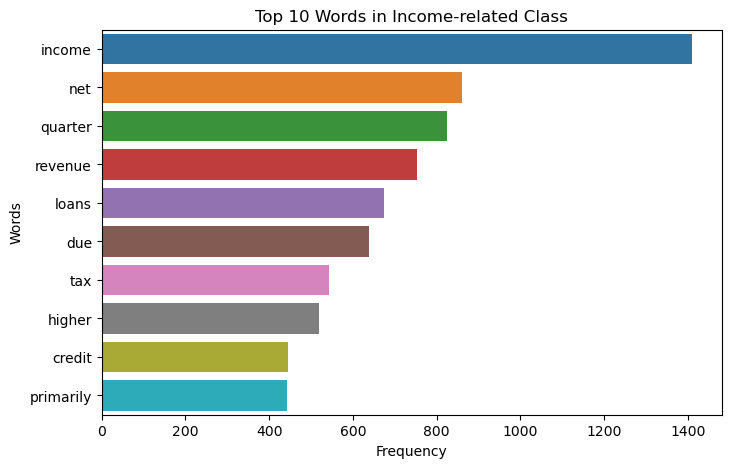

C:\Users\MIS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


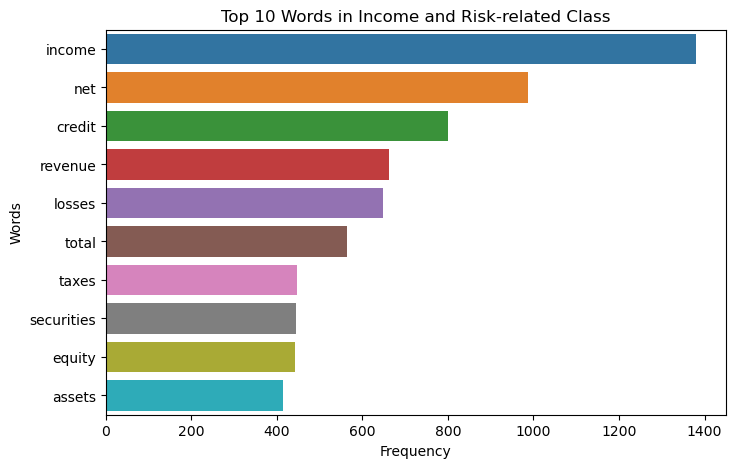

C:\Users\MIS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


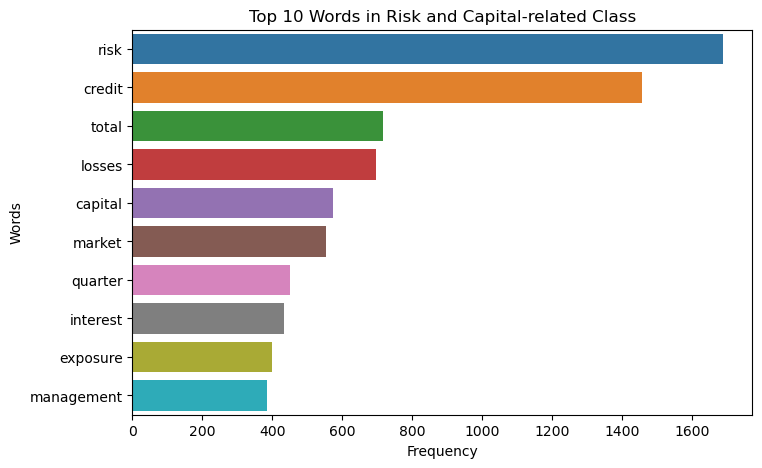

C:\Users\MIS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


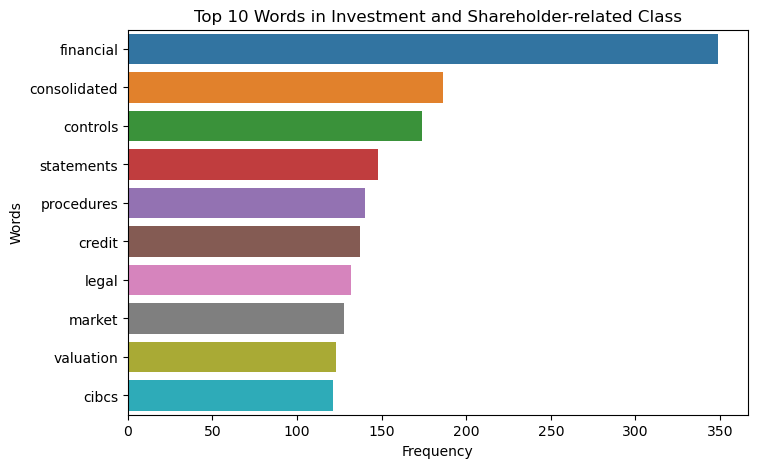

C:\Users\MIS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


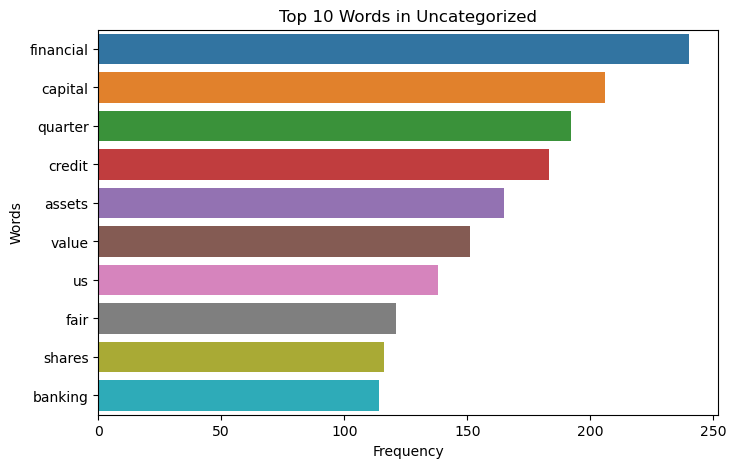

In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import pandas as pd
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def plot_top_words(df, num_words=10):
    categories = df['category'].unique()
    
    for category in categories:
        text_data = ' '.join(df[df['category'] == category]['sentence'].values).lower().split()
        text_data = [word for word in text_data if word not in stop_words]
        
        word_freq = Counter(text_data).most_common(num_words)
        if word_freq:
            words, counts = zip(*word_freq)
            plt.figure(figsize=(8, 5))
            sns.barplot(x=list(counts), y=list(words))
            plt.title(f'Top {num_words} Words in {category}')
            plt.xlabel('Frequency')
            plt.ylabel('Words')
            plt.show()

plot_top_words(df_classified)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MIS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


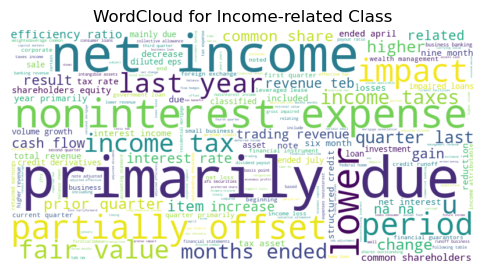

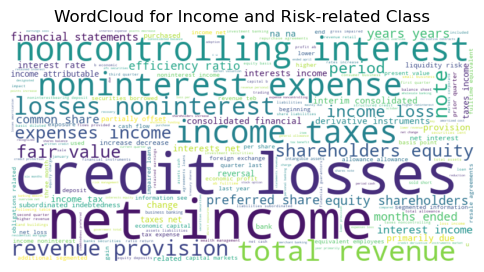

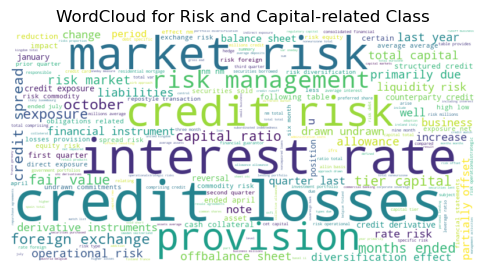

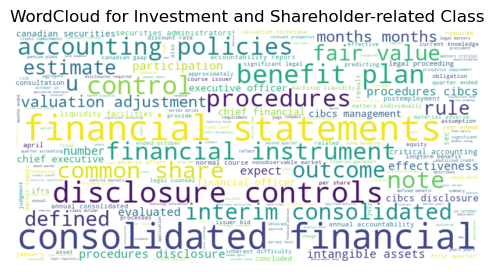

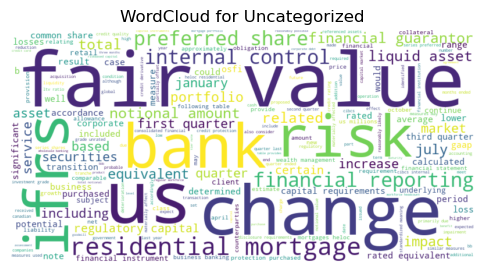

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def generate_wordclouds(df):
    categories = df['category'].unique()
    for category in categories:
        text_data = ' '.join(df[df['category'] == category]['sentence'].values).lower()
        wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='viridis').generate(text_data)

        plt.figure(figsize=(6, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud for {category}')
        plt.show()

generate_wordclouds(df_classified)


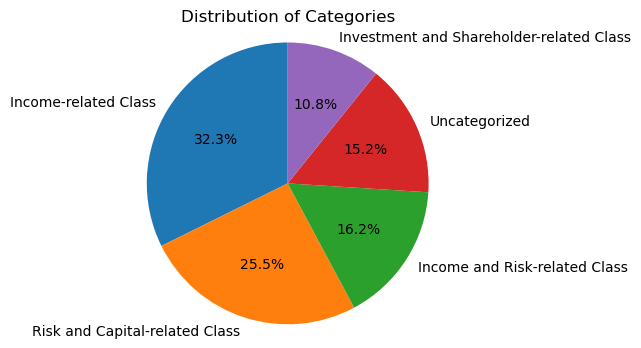

In [10]:
def plot_category_distribution(df):
    category_counts = df['category'].value_counts()
    plt.figure(figsize=(4, 4))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Categories')
    plt.axis('equal') 
    plt.show()

plot_category_distribution(df_classified)

In [11]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


C:\Users\MIS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


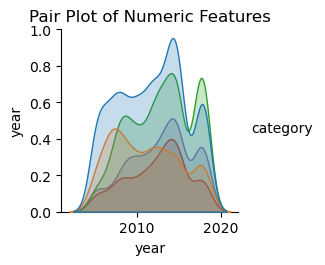

In [12]:
def plot_pair_plot(df):
    sns.pairplot(df, hue='category', diag_kind='kde')
    plt.title('Pair Plot of Numeric Features')
    plt.show()

plot_pair_plot(df_classified)


In [13]:
print(len(df_classified_test))
df_classified_test.groupby('category').size()

3158


category
Income and Risk-related Class               534
Income-related Class                        901
Investment and Shareholder-related Class    252
Risk and Capital-related Class              964
Uncategorized                               507
dtype: int64

# Lemmatization and Stop Word Removal on train and test set

In [14]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_and_remove_stopwords(text):
    lemmatized_word_list = []
    for word_token in word_tokenize(text.lower()):
        if word_token not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word_token)
            lemmatized_word_list.append(lemmatized_word)
    
    return ' '.join(lemmatized_word_list) 

df_classified['sentence'] = df_classified['sentence'].apply(lemmatize_and_remove_stopwords)
df_classified_test['sentence'] = df_classified_test['sentence'].apply(lemmatize_and_remove_stopwords)

# Classification Models with TFIDF

In [15]:
class CategoryClassificationModel:
    def __init__(self, df_classified, df_classified_test):
        self.df_classified = df_classified
        self.df_classified_test = df_classified_test

    def train_test_split(self):
        self.X = df_classified['sentence']
        self.y = df_classified['category']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42, stratify = self.y)

    def tfidf_setup(self):
        self.tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 3))

    def pipeline_setup(self):
        self.pipelines = {
            'RandomForest': Pipeline([
                ('tfidf', self.tfidf_vectorizer),
                ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
            ]),
            'NaiveBayes': Pipeline([
                ('tfidf', self.tfidf_vectorizer),
                ('clf', MultinomialNB())
            ]),
            'LogisticRegression': Pipeline([
                ('tfidf', self.tfidf_vectorizer),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))
            ])
        }

    def training_and_evaluation(self):
        for name, pipeline in self.pipelines.items():
            print("Training with model: ", name)
            pipeline.fit(self.X_train, self.y_train)
            self.y_pred = pipeline.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, self.y_pred)
            classification_rep = classification_report(self.y_test, self.y_pred)
            print(f"Accuracy: {accuracy:.2f}")
            print("Classification Report:\n", classification_rep)    

    def prediction_on_test(self):
        print(self.df_classified_test.groupby('category').size())
        self.X_test = self.df_classified_test['sentence']
        self.y_test_actual = self.df_classified_test['category']
        for name, pipeline in self.pipelines.items():
            print(f"Predicting on test data with model: {name}")
            y_pred_test = pipeline.predict(self.X_test)
            accuracy_test = accuracy_score(self.y_test_actual, y_pred_test)
            print(f"Test Accuracy for {name}: {accuracy_test:.2f}")
            classification_rep_test = classification_report(self.y_test_actual, y_pred_test)
            print(f"Classification Report for {name} on test data:\n", classification_rep_test)


category_classification_model = CategoryClassificationModel(df_classified, df_classified_test)
category_classification_model.train_test_split()
category_classification_model.tfidf_setup()
category_classification_model.pipeline_setup()
category_classification_model.training_and_evaluation()
category_classification_model.prediction_on_test()

Training with model:  RandomForest
Accuracy: 0.97
Classification Report:
                                           precision    recall  f1-score   support

           Income and Risk-related Class       0.98      0.94      0.96       183
                    Income-related Class       0.96      0.99      0.97       366
Investment and Shareholder-related Class       0.97      0.93      0.95       122
          Risk and Capital-related Class       0.98      0.99      0.98       289
                           Uncategorized       0.96      0.95      0.96       172

                                accuracy                           0.97      1132
                               macro avg       0.97      0.96      0.97      1132
                            weighted avg       0.97      0.97      0.97      1132

Training with model:  NaiveBayes
Accuracy: 0.80
Classification Report:
                                           precision    recall  f1-score   support

           Income and Risk-rel

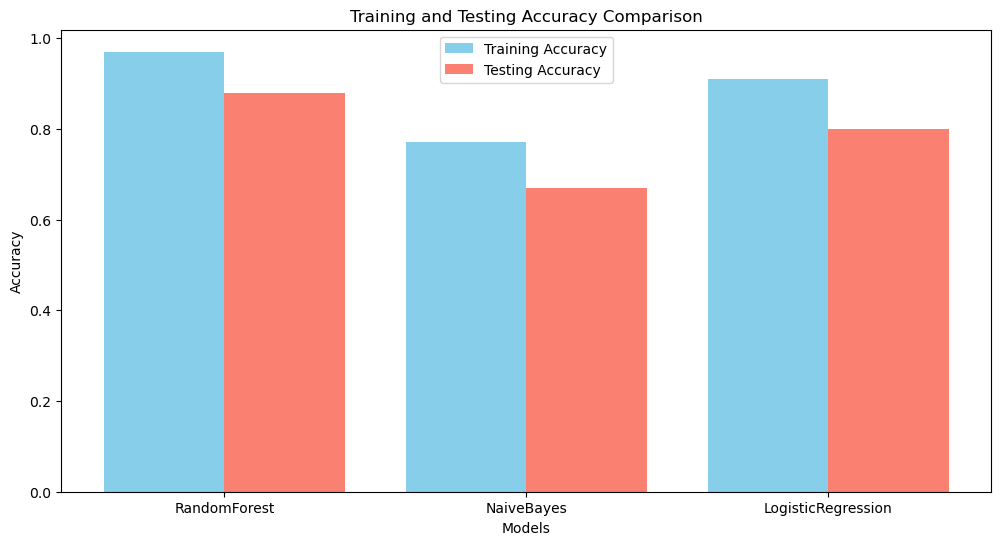

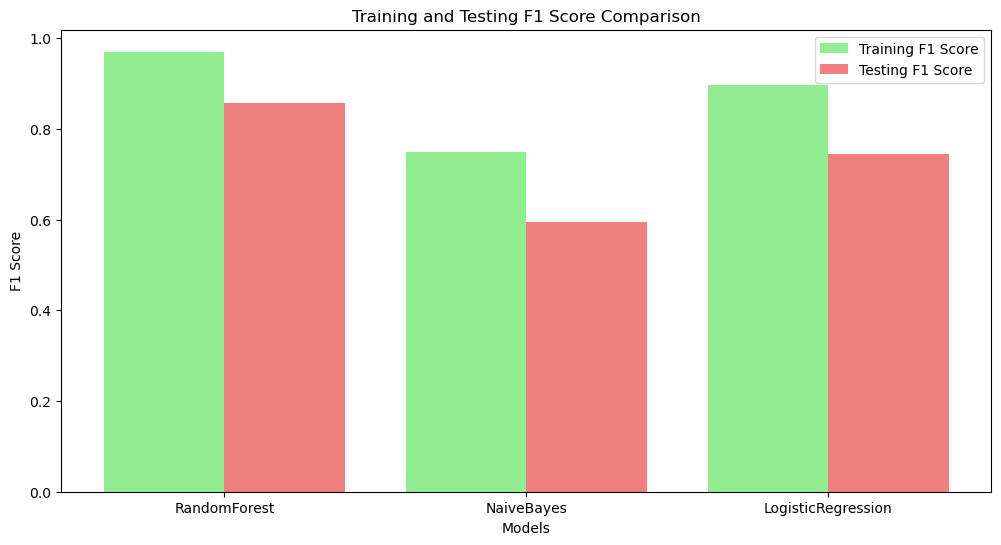

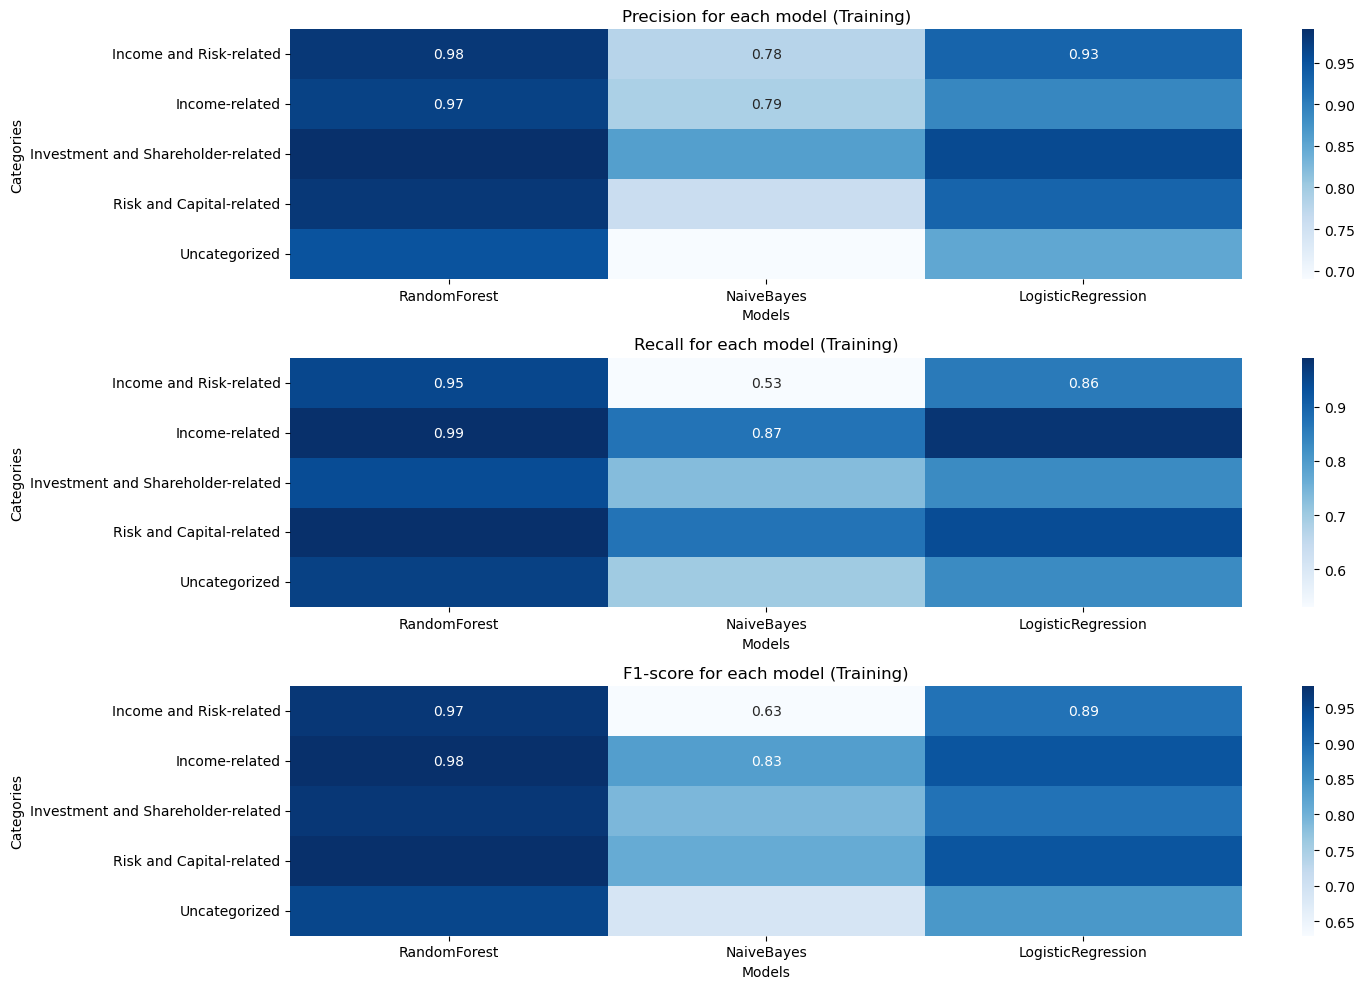

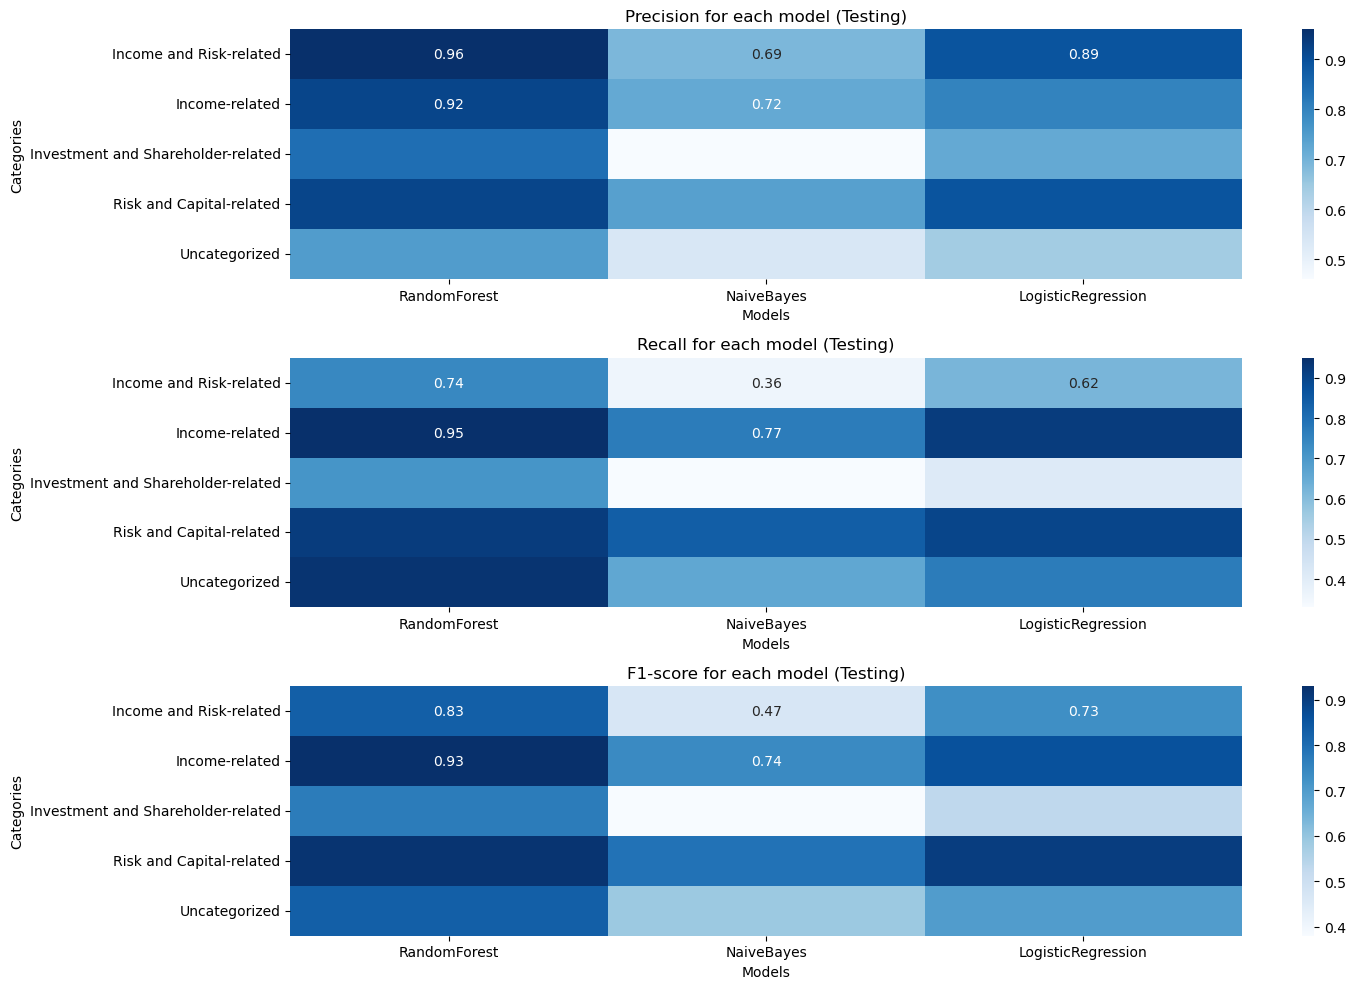

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_reports_train = {
    'RandomForest': {
        'precision': [0.98, 0.97, 0.99, 0.98, 0.95],
        'recall': [0.95, 0.99, 0.94, 0.99, 0.96],
        'f1-score': [0.97, 0.98, 0.97, 0.98, 0.95],
        'support': [183, 366, 122, 289, 174],
    },
    'NaiveBayes': {
        'precision': [0.78, 0.79, 0.86, 0.76, 0.69],
        'recall': [0.53, 0.87, 0.73, 0.87, 0.70],
        'f1-score': [0.63, 0.83, 0.79, 0.81, 0.69],
        'support': [183, 366, 122, 289, 174],
    },
    'LogisticRegression': {
        'precision': [0.93, 0.89, 0.96, 0.93, 0.85],
        'recall': [0.86, 0.98, 0.83, 0.94, 0.83],
        'f1-score': [0.89, 0.93, 0.89, 0.93, 0.84],
        'support': [183, 366, 122, 289, 174],
    }
}

class_reports_test = {
    'RandomForest': {
        'precision': [0.96, 0.92, 0.84, 0.92, 0.75],
        'recall': [0.74, 0.95, 0.71, 0.92, 0.94],
        'f1-score': [0.83, 0.93, 0.77, 0.92, 0.83],
        'support': [534, 904, 252, 977, 513],
    },
    'NaiveBayes': {
        'precision': [0.69, 0.72, 0.46, 0.74, 0.54],
        'recall': [0.36, 0.77, 0.33, 0.84, 0.66],
        'f1-score': [0.47, 0.74, 0.38, 0.79, 0.59],
        'support': [534, 904, 252, 977, 513],
    },
    'LogisticRegression': {
        'precision': [0.89, 0.80, 0.72, 0.89, 0.64],
        'recall': [0.62, 0.92, 0.41, 0.90, 0.77],
        'f1-score': [0.73, 0.86, 0.53, 0.90, 0.70],
        'support': [534, 904, 252, 977, 513],
    }
}

categories = ['Income and Risk-related', 'Income-related', 'Investment and Shareholder-related', 
              'Risk and Capital-related', 'Uncategorized']

def plot_accuracy_and_f1(class_reports_train, class_reports_test):
    model_names = list(class_reports_train.keys())
    train_accuracy = [0.97, 0.77, 0.91]
    test_accuracy = [0.88, 0.67, 0.80]

    f1_train_avg = [sum(report['f1-score']) / len(report['f1-score']) for report in class_reports_train.values()]
    f1_test_avg = [sum(report['f1-score']) / len(report['f1-score']) for report in class_reports_test.values()]

    x = np.arange(len(model_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, train_accuracy, width=0.4, label='Training Accuracy', color='skyblue')
    plt.bar(x + 0.2, test_accuracy, width=0.4, label='Testing Accuracy', color='salmon')

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, f1_train_avg, width=0.4, label='Training F1 Score', color='lightgreen')
    plt.bar(x + 0.2, f1_test_avg, width=0.4, label='Testing F1 Score', color='lightcoral')

    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('Training and Testing F1 Score Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.show()
def plot_classification_report_heatmaps(class_reports, report_type='Training'):
    metrics = ['precision', 'recall', 'f1-score']
    model_names = list(class_reports.keys())

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        scores = [report[metric] for report in class_reports.values()]
        scores = list(zip(*scores))
        plt.subplot(3, 1, i + 1)
        sns.heatmap(scores, annot=True, fmt='.2f', cmap='Blues', xticklabels=model_names, yticklabels=categories)
        plt.title(f'{metric.capitalize()} for each model ({report_type})')
        plt.xlabel('Models')
        plt.ylabel('Categories')

    plt.tight_layout()
    plt.show()
plot_accuracy_and_f1(class_reports_train, class_reports_test)
plot_classification_report_heatmaps(class_reports_train, 'Training')
plot_classification_report_heatmaps(class_reports_test, 'Testing')


# Further Fine Tuning with Word2Vec

In [17]:
class CategoryClassificationModelsWithWord2Vec():
    def __init__(self, df_classified, df_classified_test):
        self.df_classified = df_classified
        self.df_classified_test = df_classified_test

    def train_test_split(self):
        self.X = df_classified['sentence']
        self.y = df_classified['category']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42, stratify = self.y)

    def text_to_word_tokeninze(self):
        self.sentences = [word_tokenize(text.lower()) for text in self.X_train]

    def define_word2vec_model(self):
        self.word2vec_model = Word2Vec(self.sentences, vector_size=200, window=5, min_count=10, workers=4)

    def text_to_vector(self, text):
        word_tokens = word_tokenize(text.lower())
        word_vector_list = [self.word2vec_model.wv[word] for word in word_tokens if word in self.word2vec_model.wv]
        if len(word_vector_list) > 0:
            return np.mean(word_vector_list, axis=0)
        else:
            return np.zeros(self.word2vec_model.vector_size)

    def custom_word2vec_transform(self, X):
        return np.array([self.text_to_vector(text) for text in X])

    def pipeline_setup(self):
        self.pipelines = {
            'RandomForest': Pipeline([
                ('word2vec', 'passthrough'),
                ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
            ]),
            'LogisticRegression': Pipeline([
                ('word2vec', 'passthrough'),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))
            ])
        }

    def training_and_evaluation(self):
        for name, pipeline in self.pipelines.items():
            print("Training with model: ", name)
            self.X_train_vec = self.custom_word2vec_transform(self.X_train)
            self.X_test_vec = self.custom_word2vec_transform(self.X_test)
            pipeline.fit(self.X_train_vec, self.y_train)
            self.y_pred = pipeline.predict(self.X_test_vec)
            accuracy = accuracy_score(self.y_test, self.y_pred)
            classification_rep = classification_report(self.y_test, self.y_pred)
            print(f"Accuracy: {accuracy:.2f}")
            print("Classification Report:\n", classification_rep)

    def prediction_on_test(self):
        for name, pipeline in self.pipelines.items():
            print(f"Predicting with model: {name}")
            self.X_test_actual = self.df_classified_test['sentence']
            self.y_test_actual = self.df_classified_test['category']
            self.X_test_actual_vec = self.custom_word2vec_transform(self.X_test_actual)
            y_pred_test = pipeline.predict(self.X_test_actual_vec)
            accuracy_test = accuracy_score(self.y_test_actual, y_pred_test)
            classification_rep_test = classification_report(self.y_test_actual, y_pred_test)
            print(f"Test Accuracy for {name}: {accuracy_test:.2f}")
            print(f"Classification Report for {name} on test data:\n", classification_rep_test)


category_classification_model = CategoryClassificationModelsWithWord2Vec(df_classified, df_classified_test)
category_classification_model.train_test_split()
category_classification_model.text_to_word_tokeninze()
category_classification_model.define_word2vec_model()
category_classification_model.pipeline_setup()
category_classification_model.training_and_evaluation()
category_classification_model.prediction_on_test()

Training with model:  RandomForest
Accuracy: 0.91
Classification Report:
                                           precision    recall  f1-score   support

           Income and Risk-related Class       0.93      0.88      0.90       183
                    Income-related Class       0.91      0.96      0.93       366
Investment and Shareholder-related Class       0.92      0.89      0.90       122
          Risk and Capital-related Class       0.92      0.94      0.93       289
                           Uncategorized       0.90      0.83      0.86       172

                                accuracy                           0.91      1132
                               macro avg       0.92      0.90      0.91      1132
                            weighted avg       0.91      0.91      0.91      1132

Training with model:  LogisticRegression
Accuracy: 0.66
Classification Report:
                                           precision    recall  f1-score   support

           Income and 

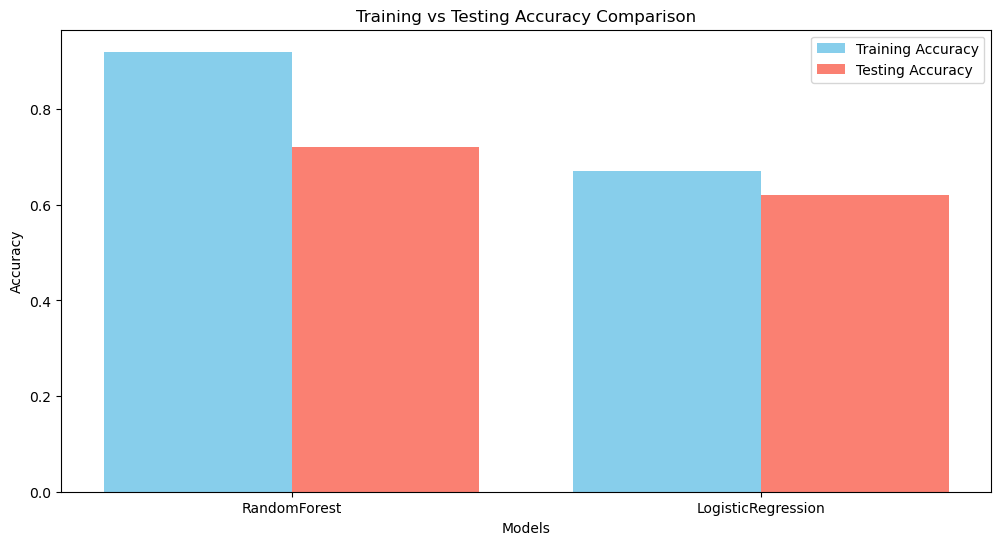

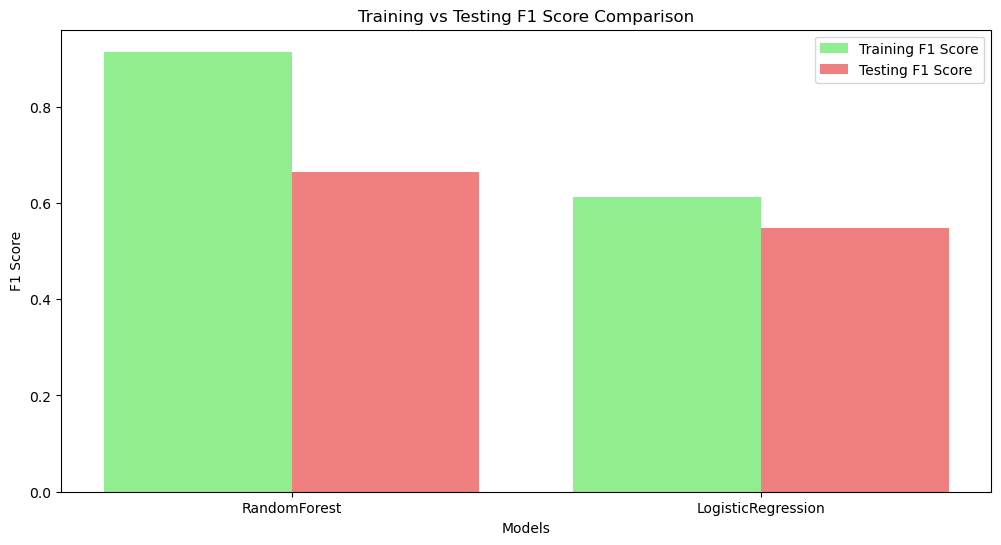

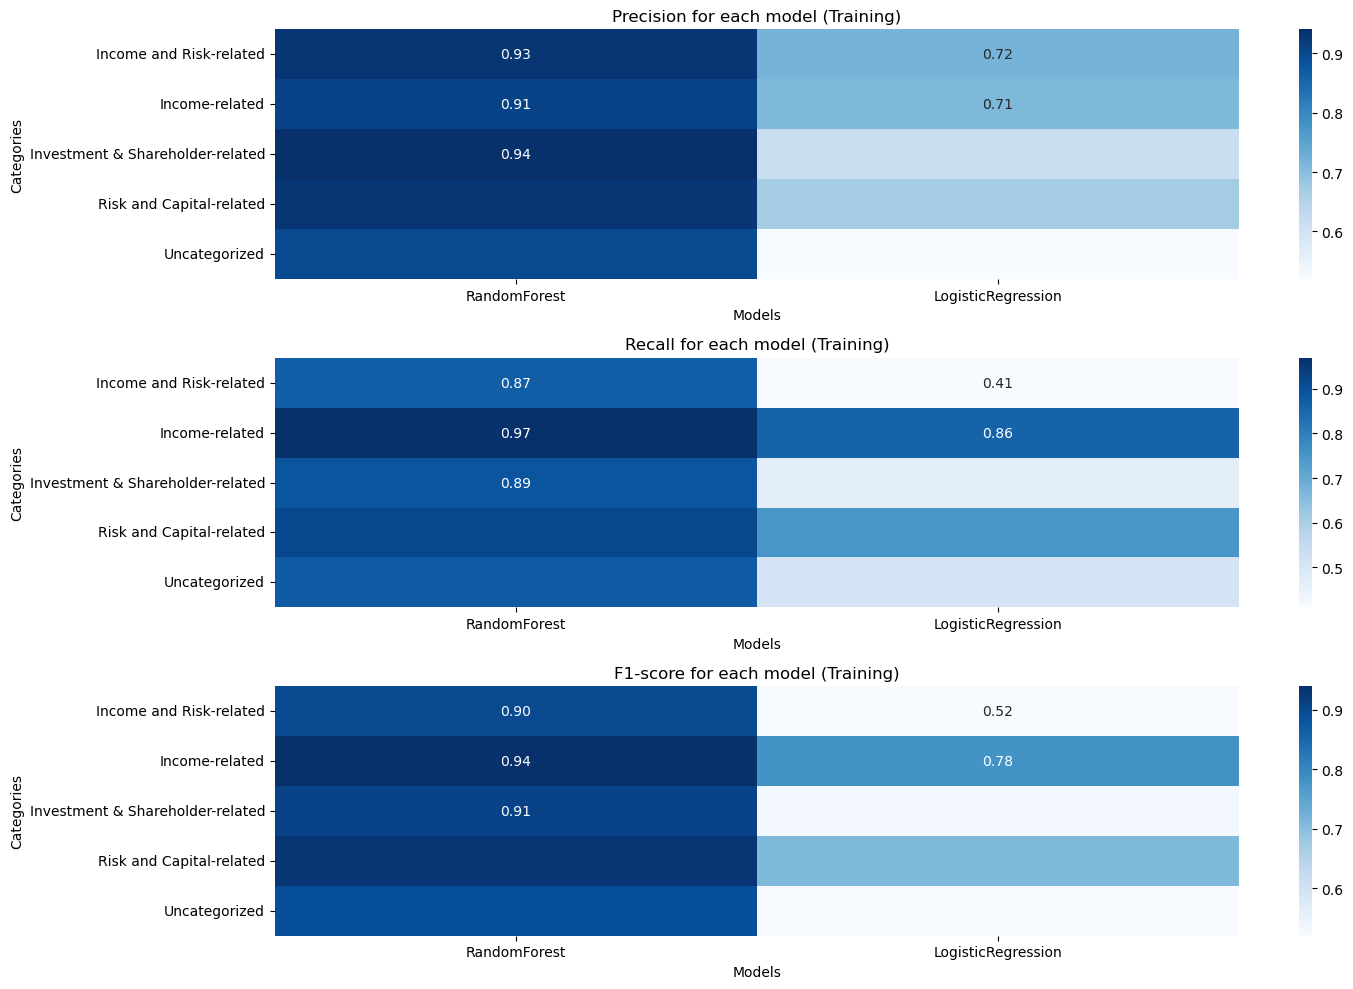

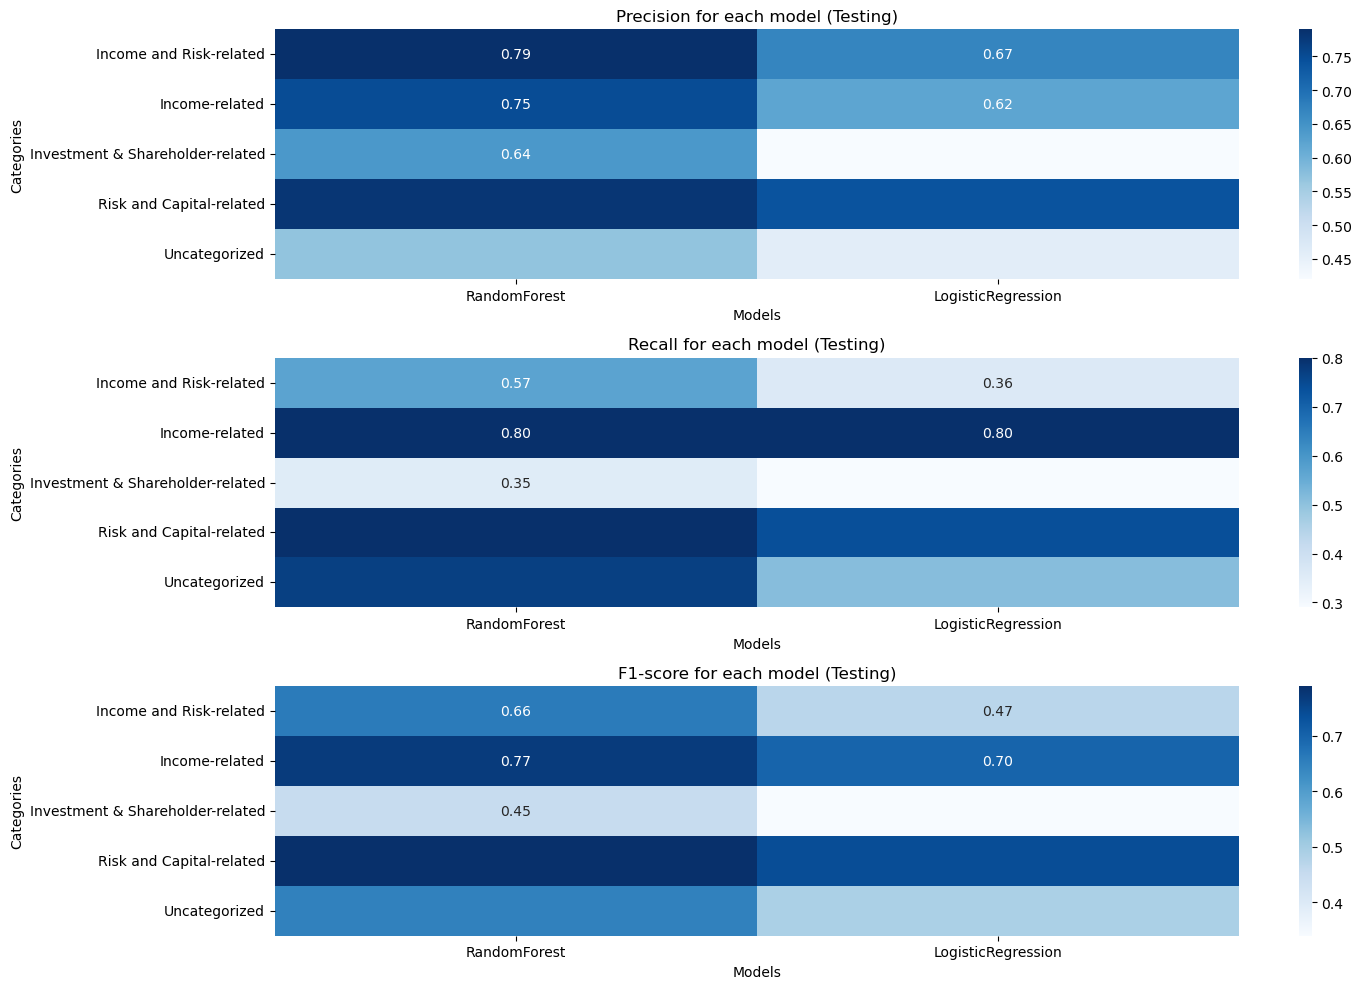

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_reports_train = {
    'RandomForest': {
        'precision': [0.93, 0.91, 0.94, 0.93, 0.90],
        'recall': [0.87, 0.97, 0.89, 0.92, 0.88],
        'f1-score': [0.90, 0.94, 0.91, 0.93, 0.89],
        'support': [183, 366, 122, 289, 172],
        'accuracy': 0.92
    },
    'LogisticRegression': {
        'precision': [0.72, 0.71, 0.62, 0.67, 0.52],
        'recall': [0.41, 0.86, 0.47, 0.75, 0.51],
        'f1-score': [0.52, 0.78, 0.53, 0.71, 0.52],
        'support': [183, 366, 122, 289, 172],
        'accuracy': 0.67
    }
}

class_reports_test = {
    'RandomForest': {
        'precision': [0.79, 0.75, 0.64, 0.78, 0.57],
        'recall': [0.57, 0.80, 0.35, 0.80, 0.77],
        'f1-score': [0.66, 0.77, 0.45, 0.79, 0.65],
        'support': [534, 901, 252, 964, 507],
        'accuracy': 0.72
    },
    'LogisticRegression': {
        'precision': [0.67, 0.62, 0.42, 0.74, 0.46],
        'recall': [0.36, 0.80, 0.29, 0.74, 0.51],
        'f1-score': [0.47, 0.70, 0.34, 0.74, 0.49],
        'support': [534, 901, 252, 964, 507],
        'accuracy': 0.62
    }
}

categories = ['Income and Risk-related', 'Income-related', 
              'Investment & Shareholder-related', 'Risk and Capital-related', 'Uncategorized']

def plot_accuracy_and_f1(train_reports, test_reports):
    model_names = list(train_reports.keys())
    train_accuracy = [report['accuracy'] for report in train_reports.values()]
    test_accuracy = [report['accuracy'] for report in test_reports.values()]

    f1_train_avg = [np.mean(report['f1-score']) for report in train_reports.values()]
    f1_test_avg = [np.mean(report['f1-score']) for report in test_reports.values()]

    x = np.arange(len(model_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, train_accuracy, width=0.4, label='Training Accuracy', color='skyblue')
    plt.bar(x + 0.2, test_accuracy, width=0.4, label='Testing Accuracy', color='salmon')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, f1_train_avg, width=0.4, label='Training F1 Score', color='lightgreen')
    plt.bar(x + 0.2, f1_test_avg, width=0.4, label='Testing F1 Score', color='lightcoral')
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('Training vs Testing F1 Score Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.show()

def plot_classification_report_heatmaps(reports, report_type='Training'):
    metrics = ['precision', 'recall', 'f1-score']
    model_names = list(reports.keys())

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        scores = [report[metric] for report in reports.values()]
        scores = list(zip(*scores))
        plt.subplot(3, 1, i + 1)
        sns.heatmap(scores, annot=True, fmt='.2f', cmap='Blues', 
                    xticklabels=model_names, yticklabels=categories)
        plt.title(f'{metric.capitalize()} for each model ({report_type})')
        plt.xlabel('Models')
        plt.ylabel('Categories')

    plt.tight_layout()
    plt.show()

plot_accuracy_and_f1(class_reports_train, class_reports_test)
plot_classification_report_heatmaps(class_reports_train, 'Training')
plot_classification_report_heatmaps(class_reports_test, 'Testing')


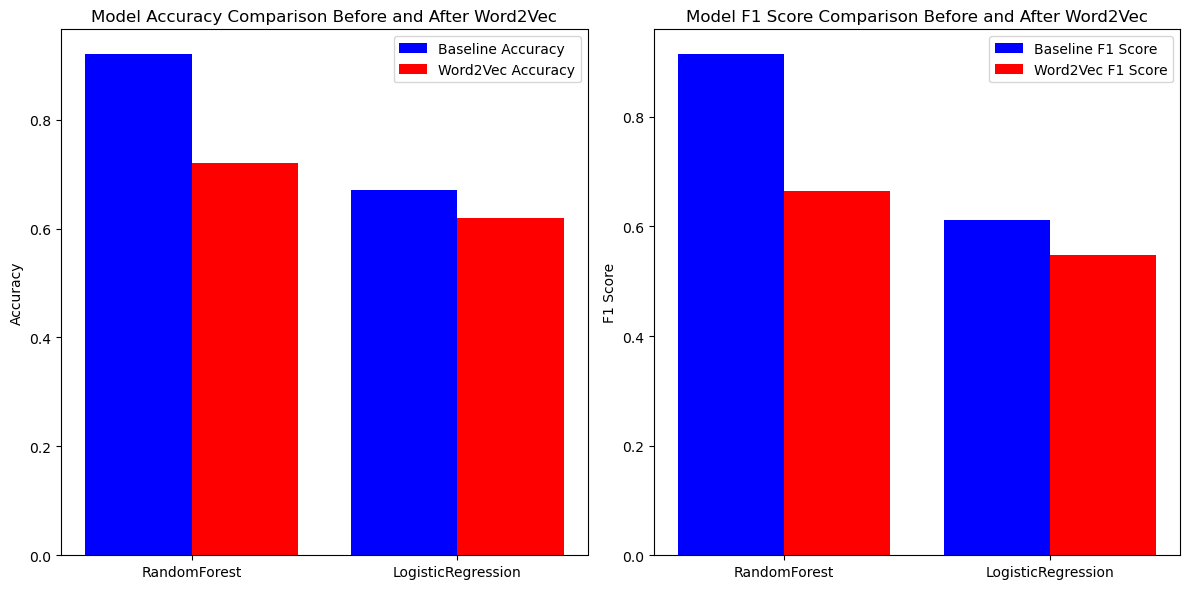

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

class_reports_baseline = {
    'RandomForest': {
        'precision': [0.93, 0.91, 0.94, 0.93, 0.90],
        'recall': [0.87, 0.97, 0.89, 0.92, 0.88],
        'f1-score': [0.90, 0.94, 0.91, 0.93, 0.89],
        'support': [183, 366, 122, 289, 172],
    },
    'LogisticRegression': {
        'precision': [0.72, 0.71, 0.62, 0.67, 0.52],
        'recall': [0.41, 0.86, 0.47, 0.75, 0.51],
        'f1-score': [0.52, 0.78, 0.53, 0.71, 0.52],
        'support': [183, 366, 122, 289, 172],
    }
}

class_reports_word2vec = {
    'RandomForest': {
        'precision': [0.79, 0.75, 0.64, 0.78, 0.57],
        'recall': [0.57, 0.80, 0.35, 0.80, 0.77],
        'f1-score': [0.66, 0.77, 0.45, 0.79, 0.65],
        'support': [534, 901, 252, 964, 507],
    },
    'LogisticRegression': {
        'precision': [0.67, 0.62, 0.42, 0.74, 0.46],
        'recall': [0.36, 0.80, 0.29, 0.74, 0.51],
        'f1-score': [0.47, 0.70, 0.34, 0.74, 0.49],
        'support': [534, 901, 252, 964, 507],
    }
}


model_names = list(class_reports_baseline.keys())

def plot_comparison_before_after(class_reports_baseline, class_reports_word2vec):
    f1_avg_baseline = [sum(report['f1-score']) / len(report['f1-score']) for report in class_reports_baseline.values()]
    f1_avg_word2vec = [sum(report['f1-score']) / len(report['f1-score']) for report in class_reports_word2vec.values()]

    accuracies_baseline = [0.92, 0.67]  
    accuracies_word2vec = [0.72, 0.62]  

    x = range(len(model_names))  
    plt.figure(figsize=(12, 6))

    
    plt.subplot(1, 2, 1)
    plt.bar(x, accuracies_baseline, width=0.4, label='Baseline Accuracy', color='b', align='center')
    plt.bar([p + 0.4 for p in x], accuracies_word2vec, width=0.4, label='Word2Vec Accuracy', color='r', align='center')
    plt.xticks([p + 0.2 for p in x], model_names)
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison Before and After Word2Vec')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.bar(x, f1_avg_baseline, width=0.4, label='Baseline F1 Score', color='b', align='center')
    plt.bar([p + 0.4 for p in x], f1_avg_word2vec, width=0.4, label='Word2Vec F1 Score', color='r', align='center')
    plt.xticks([p + 0.2 for p in x], model_names)
    plt.ylabel('F1 Score')
    plt.title('Model F1 Score Comparison Before and After Word2Vec')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison_before_after(class_reports_baseline, class_reports_word2vec)


# Chat bot based on Quater 3 2024 Report

## Extract Quarter 3 report text

In [27]:
import fitz
'''
The purpose of this class is to read pdf text from quarter 3 2024 report and save the extracted text to txt file
Steps followed
1. open pdf file with fitz
2. extract all text
3. store extracted text to txt file
'''

class Q3ReportTextExtractor:
    def __init__(self, pdf_path):
        self.pdf_path = pdf_path
        self.pdf_document = None
        self.pdf_text = ''

    def open_pdf(self):
        try:
            self.pdf_document = fitz.open(self.pdf_path)
        except Exception as e:
            print("Error opening PDF: ", e)

    def extract_text(self):
        if self.pdf_document is None:
            print("PDF file is not opened. Please open the PDF file first.")
            return

        for page_num in range(len(self.pdf_document)):
            page = self.pdf_document.load_page(page_num)  # Load page
            self.pdf_text += page.get_text("text")

    def write_text_to_file(self, output_path):
        with open(output_path, 'w', encoding='utf-8') as file:
            file.write(self.pdf_text)
        print("Text successfully written to", output_path)


extractor = Q3ReportTextExtractor('cibc_quarterly_reports/cibc_q3_2024.pdf')
extractor.open_pdf()
extractor.extract_text()
extractor.write_text_to_file('extracted_text.txt')


Text successfully written to extracted_text.txt


In [21]:
pip install pymupdf

Note: you may need to restart the kernel to use updated packages.


## Clean text and Extract patterns

In [28]:
'''
The purpose of FinancialTextExtractor class is to extract numbers for revenue, net income, earnings per share, return on equity, adjusted return on equity,
Net Interest Income, Credit Losses, Efficiency Ratio, Operating Leverage, CET1 Ratio
'''
class FinancialTextExtractor:
    def __init__(self, text):
        self.text = text

    def clean_text(self):
        self.text = re.sub(r'\s+', ' ', self.text)
        self.text = re.sub(r'CIBC THIRD QUARTER \d{4} \d+', '', self.text)
        self.text = re.sub(r'For additional information.*?statement.', '', self.text, flags=re.IGNORECASE) 
        self.text = re.sub(r'\(\d+\)', '', self.text)
        self.text = re.sub(r'\s{2,}', ' ', self.text) 
        return self.text

    def extract_financial_metrics(self):
        cleaned_text = self.clean_text()
        metrics_patterns = {
            'Revenue': r'(total revenue|revenue)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'Net Income': r'(net income|net earnings)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'EPS': r'(earnings per share|EPS|diluted earnings per share)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'ROE': r'(return on equity|ROE|Return on Common Shareholders’ Equity)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'Adjusted ROE': r'(adjusted return on equity|adjusted ROE)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'Net Interest Income': r'(net interest income)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'Credit Losses': r'(credit losses|provision for credit losses)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'Efficiency Ratio': r'(efficiency ratio)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'Operating Leverage': r'(operating leverage)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)',
            'CET1 Ratio': r'(common equity tier 1|CET1 ratio)\s*[^\d]*([\d,]+\.\d+|\d[\d,]*)'
        }

        financial_data = {}
        for metric, pattern in metrics_patterns.items():
            match = re.search(pattern, cleaned_text, re.IGNORECASE)
            if match:
                financial_data[metric] = match.group(2)  # Only store the value
            else:
                financial_data[metric] = 'Not found'
        return financial_data

    def get_report_insights(self):
        financial_insights = self.extract_financial_metrics()
        insights_data = {
            'Revenue': financial_insights['Revenue'],
            'Net Income': financial_insights['Net Income'],
            'EPS': financial_insights['EPS'],
            'ROE': financial_insights['ROE'],
            'Adjusted ROE': financial_insights['Adjusted ROE'],
            'Net Interest Income': financial_insights['Net Interest Income'],
            'Credit Losses': financial_insights['Credit Losses'],
            'Efficiency Ratio': financial_insights['Efficiency Ratio'],
            'Operating Leverage': financial_insights['Operating Leverage'],
            'CET1 Ratio': financial_insights['CET1 Ratio']
        }
        df_insights = pd.DataFrame([insights_data])
        return df_insights

with open('extracted_text.txt', 'r', encoding='utf-8') as file:
    extracted_text = file.read()

extractor = FinancialTextExtractor(extracted_text)
df_report_insights = extractor.get_report_insights()


## Basic chatbot

In [30]:
class Q3ReportChatbot:
    def __init__(self, df):
        self.df = df

    def find_answer(self, query):
        query = query.lower()

        query_column_map = {
            'revenue': 'Revenue',
            'net income': 'Net Income',
            'profit': 'Net Income',
            'eps': 'EPS',
            'earnings per share': 'EPS',
            'roe': 'ROE',
            'return on equity': 'ROE',
            'adjusted roe': 'Adjusted ROE',
            'net interest income': 'Net Interest Income',
            'credit losses': 'Credit Losses',
            'efficiency ratio': 'Efficiency Ratio',
            'operating leverage': 'Operating Leverage',
            'cet1': 'CET1 Ratio',
            'common equity tier': 'CET1 Ratio',
            'economic outlook': 'Economic Outlook',
            'community initiatives': 'Community Initiatives'
        }
        for keyword, column in query_column_map.items():
            if keyword in query:
                if column in self.df.columns:
                    return f"{column}: {self.df[column].values[0]}"
                else:
                    return f"Data for {column} is not available."

        return "I cannot find the answer to your question. If you want to exit, type 'quit/exit'."

chatbot = Q3ReportChatbot(df_report_insights)

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Chatbot: Goodbye! Have a good day!")
        break
    response = chatbot.find_answer(user_input)
    print(f"Chatbot: {response}")

You:  How much revenue did CIBC generate in Q3 2024?



Chatbot: The value for Revenue is: 6,604


You:  What was CIBC's net income for Q3 2024?



Chatbot: The value for Net Income is: 1,795


You:  What was CIBC's Common Equity Tier 1 (CET1) ratio?



Chatbot: The value for CET1 Ratio is: 1


You:  exit


Chatbot: Goodbye! Have a good day!
